This notebook contains the code to the final experiment of the thesis. The goal is to align elements such that they have a proper spacing and are aligned on one side. This is the dumbed down version of the original experiment of this thesis.

We will use IoU (Intersection over Union) as the metric for proper alignment.

In [183]:
!pip uninstall -y fastai && pip install -q fastai==1.0.61

In [184]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn.functional as F
import torchvision.transforms as T

from PIL import Image
import json
from math import prod
from huggingface_hub import hf_hub_download
import tqdm
transform_t_to_pil = T.ToPILImage()
transform_to_t = transforms.Compose([transforms.ToTensor()])
import utils
from utils import get_all_bounding_boxes, segment, calculate_initial_theta, stack_alpha_aware, AestheticPredictor, get_random_initial_position
# from lion_pytorch import Lion
from datetime import datetime
import random
from huggingface_hub import hf_hub_download
import timm
import torch.nn as nn

In [185]:
import fastai

In [186]:
appsthetics_predictor = torch.load("../Dataset_estetica/Regressao/model123")

In [3]:
# Transformations
resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
device = "cpu"

In [5]:
im = Image.open('../combined/5373.jpg')
im = im.convert('RGBA')
im = im.resize((1440, 2560), Image.Resampling.LANCZOS)


with open('../combined/5373.json', "r") as f:
    image_json = json.load(f)

reduced_segments = [s for s in segment(im,image_json) if (prod(s[0].size) < 0.80*prod(im.size)) and (prod(s[0].size)>1)]

In [6]:
im.size

(1440, 2560)

In [7]:
def get_all_bounding_boxes(item):
    all_boxes = []
    if "bounds" in item.keys() and "resource-id" in item.keys():
        all_boxes.append((item["bounds"],item["resource-id"]))
    if "children" in item.keys():
        for child in item["children"]:
            for box in get_all_bounding_boxes(child):
                all_boxes.append(box)
    return all_boxes

In [8]:
reduced_segments

[(<PIL.Image.Image image mode=RGBA size=168x168>, (1272, 84)),
 (<PIL.Image.Image image mode=RGBA size=848x142>, (112, 373)),
 (<PIL.Image.Image image mode=RGBA size=888x242>, (112, 571)),
 (<PIL.Image.Image image mode=RGBA size=444x76>, (112, 917)),
 (<PIL.Image.Image image mode=RGBA size=327x168>, (1113, 2224)),
 (<PIL.Image.Image image mode=RGBA size=1440x168>, (0, 2392)),
 (<PIL.Image.Image image mode=RGBA size=1440x84>, (0, 0))]

In [170]:
class MultiSegmentUIOptimizer(torch.nn.Module):
    def __init__(self,segments_and_positions: list, original_image_size: tuple):
        super().__init__()
        self.original_image_size = original_image_size
        self.segments_and_positions = segments_and_positions
        self.canvas_size = (1,3,original_image_size[1],original_image_size[0])
        print(f"Canvas size is {self.canvas_size}")

        initial_vector = []
        for segment,position in segments_and_positions:
            #initial_theta = calculate_initial_theta(segment,original_image_size,position)
            # initial_theta = get_random_initial_position(segment,original_image_size,position)
            #initial_vector.append([initial_theta[0][2],initial_theta[1][2]])
            initial_vector.append([0.0,0.0])

        self.coordinates = torch.nn.Parameter(torch.tensor(initial_vector))
        print(self.coordinates)
        self.background_color = torch.tensor(np.array([1.0,1.0,1.0]),dtype=torch.float)
        

    def forward(self):
        segments_on_canvas = []

        # Create background image from parameter
        bg_col = torch.clamp(self.background_color, min=0, max=1)
        #print(f"Clamped bg to {bg_col}")
        red = torch.tile(bg_col[0],self.original_image_size[::-1])
        green = torch.tile(bg_col[1],self.original_image_size[::-1])
        blue = torch.tile(bg_col[2],self.original_image_size[::-1])
        alpha = torch.tile(torch.tensor(1.0),self.original_image_size[::-1])
        background = torch.stack([red,green,blue,alpha]).unsqueeze(0)
        #print(background.detach().sum())
        #background = torch.tile(self.background_color,self.original_image_size)
        
        segments_on_canvas.append(background)
        
        for n in range(len(self.segments_and_positions)):
            # We need to calculate the proper ratios, to artificially warp the segment on to a bigger canvas without distorting it (see notebook 01)
            x_ratio = self.original_image_size[0] / self.segments_and_positions[n][0].size[0]
            y_ratio = self.original_image_size[1] / self.segments_and_positions[n][0].size[1]
            
            # Affine matrix
            theta = [
                [x_ratio, 0.0    , 0.0],
                [0.0    , y_ratio, 0.0]
            ]
            theta_tensor = torch.as_tensor(theta)[None]

            theta_tensor[0][0][2]+=self.coordinates[n][0]
            theta_tensor[0][1][2]+=self.coordinates[n][1]
            
            # Generate flow field
            grid = F.affine_grid(theta_tensor, self.canvas_size).type(torch.FloatTensor)
            x = F.grid_sample(transform_to_t(self.segments_and_positions[n][0]).unsqueeze(0), grid)
            segments_on_canvas.append(x)



        return segments_on_canvas

In [171]:
msUIo_wbg = MultiSegmentUIOptimizer(reduced_segments, im.size)

Canvas size is (1, 3, 2560, 1440)
Parameter containing:
tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], requires_grad=True)


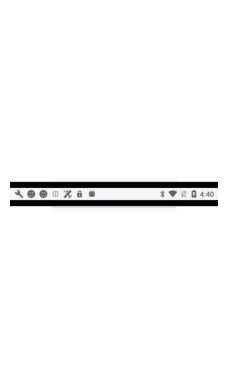

In [172]:
canvasses = msUIo_wbg()


generated_image = stack_alpha_aware(canvasses)
# Remove Alpha channel
generated_image = generated_image[:3]

plt.imshow(generated_image.detach().permute(1, 2, 0))

plt.axis('off')
plt.show()

In [173]:
def calculate_iou(boxA, boxB):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    
    Parameters:
    boxA (tuple): A tuple (x1, y1, x2, y2) representing the first bounding box.
    boxB (tuple): A tuple (x1, y1, x2, y2) representing the second bounding box.
    
    Returns:
    float: IoU value between 0 and 1.
    """

    # Determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection rectangle
    interWidth = max(0, xB - xA)
    interHeight = max(0, yB - yA)
    interArea = interWidth * interHeight

    # Compute the area of both the bounding boxes
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # Compute the area of the union
    unionArea = boxAArea + boxBArea - interArea

    # Compute the IoU
    iou = interArea / float(unionArea)
    
    return iou

def get_xy(canvas_size, segment, coordinates):
    eps = 0.00001 # Avoid div by zero
    
    x_ratio = (canvas_size[0] / segment.size[0]) + eps
    y_ratio = (canvas_size[1] / segment.size[1]) + eps
        
    original_position = [0,0]
    mapped_x_position, mapped_y_position = coordinates[0], coordinates[1]

    original_x_position = ((mapped_x_position  -(x_ratio-1)) / (-(x_ratio - 1) - (x_ratio - 1)))
    
    original_position[0] = original_x_position * (im.size[0]-segment.size[0]+eps)

    original_y_position = ((mapped_y_position -(y_ratio-1)) / (-(y_ratio - 1) - (y_ratio - 1))) 
    original_position[1] = original_y_position * (im.size[1]-segment.size[1]+eps)

    size = segment.size
    x1,y1,x2,y2 = [original_position[0],original_position[1],original_position[0]+size[0],original_position[1]+size[1]]
    return [x1,y1,x2,y2]

def criterion(coordinates,segments,canvas_size):
    ious = []
        
    for second_segment in range(len(coordinates)):
        second_xy = get_xy(canvas_size, segments[second_segment], coordinates[second_segment])
        for segment in range(len(coordinates)):
            if segment == second_segment:
                continue
                # pass
            xy = get_xy(canvas_size, segments[segment], coordinates[segment])
            ious.append(calculate_iou(xy,second_xy))
    
    return sum(ious) / len(ious)

In [174]:
msUIo_wbg.coordinates

Parameter containing:
tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], requires_grad=True)

In [175]:
criterion(msUIo_wbg.coordinates, [x[0] for x in reduced_segments], im.size)

tensor(0.3018, grad_fn=<DivBackward0>)

In [176]:
[x[0] for x in reduced_segments][0].size[0]

168

In [177]:
reduced_segments[0][0].size

(168, 168)

In [189]:
optimizer = torch.optim.AdamW(msUIo_wbg.parameters(), lr=0.5)

In [192]:
scores = []
random_losses = []
combined_losses = []
images_for_gif = []
ious = []


for x in tqdm.tqdm(range(100)):
    optimizer.zero_grad()
    canvasses = msUIo_wbg()
    
    generated_image = stack_alpha_aware(canvasses)
    # Remove Alpha channel
    generated_image = generated_image[:3]

    score = appsthetics_predictor["model"](generated_image.unsqueeze(0))
    print(f"Aesthetics Score: {score.detach().item()} (Loss: {1- score.detach().item()})")

    iou_score = criterion(msUIo_wbg.coordinates, [x[0] for x in reduced_segments], im.size)
    print(f"IoU score: {iou_score}")
    ious.append(iou_score)
    loss = iou_score
    loss.backward()
    optimizer.step()
    # scheduler.step()

    scores.append(score.detach().item())

    # Save image as png to create gif
    pil_image = transform_t_to_pil(generated_image.detach())
    pil_image = pil_image.resize((int(pil_image.size[0]/4),int(pil_image.size[1]/4)), Image.Resampling.LANCZOS)
    pil_image.save(f"output/{x}.png")
    images_for_gif.append(f"output/{x}.png")
    #pbar.set_description(f"Score: {score}")
    #pbar.refresh()

print(f"Final Score: {score[-1]}")

  0%|          | 0/100 [00:00<?, ?it/s]

Aesthetics Score: 0.4470492899417877 (Loss: 0.5529507100582123)
IoU score: 0.30176979303359985


  1%|          | 1/100 [00:03<06:28,  3.92s/it]

Aesthetics Score: 0.5004582405090332 (Loss: 0.4995417594909668)
IoU score: 0.30176979303359985


  2%|▏         | 2/100 [00:06<05:24,  3.31s/it]

Aesthetics Score: 0.5445227026939392 (Loss: 0.4554772973060608)
IoU score: 0.2992900311946869


  3%|▎         | 3/100 [00:11<06:14,  3.86s/it]


KeyboardInterrupt: 

In [193]:
msUIo_wbg.coordinates

Parameter containing:
tensor([[-1.1317, -1.1317],
        [-1.1317, -1.1317],
        [-1.1317, -1.1317],
        [-1.1317, -1.1317],
        [-1.1317, -1.1317],
        [-1.1317, -1.1317],
        [-1.1317, -1.1317]], requires_grad=True)